## Imports

In [1]:
import pandas as pd
import numpy as np
import json
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_squared_error, mean_absolute_error

## File Extraction - Amazon Data

In [2]:
file_path = '../DataInputs/Weekly/amazon_weekly_close_vol.json' # path of json file

# Load JSON data from file
with open(file_path, 'r') as file:
    data = json.load(file)

# Convert data to pandas DataFrame
df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df['Adjusted_Close'] = pd.to_numeric(df['Adjusted_Close'])
df['Volume'] = pd.to_numeric(df['Volume'])
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)

## Splitting Dataset - Training & Test

- train_df, used for training the ARIMA model
- test_df, used for comparing the prediction the model makes to the values in test df

In [3]:
# Split the data into training and test sets
train_df = df[df.index <= '2023-03-31']
test_df = df[(df.index >= '2023-03-31') & (df.index <= '2023-05-26')] # use to test the model and compare at the end


# Check the last date in the training set and the first date in the test set
print("Last date in training set:", train_df.index[-1])
print("First date in test set:", test_df.index[0])

# Check the last few rows of the training set
print(train_df.tail())

#training data set is now the main dataframe
df = train_df.copy()

# Check the first few rows of the test set
print(test_df.head())


Last date in training set: 2023-03-31 00:00:00
First date in test set: 2023-03-31 00:00:00
            Adjusted_Close     Volume
Date                                 
2023-03-03           94.90  255063564
2023-03-10           90.73  272158346
2023-03-17           98.95  375900695
2023-03-24           98.13  292165662
2023-03-31          103.29  245608340
            Adjusted_Close     Volume
Date                                 
2023-03-31          103.29  245608340
2023-04-06          102.06  178781642
2023-04-14          102.51  273789699
2023-04-21          106.96  282451994
2023-04-28          105.45  487100756


## Training Dataset Graph

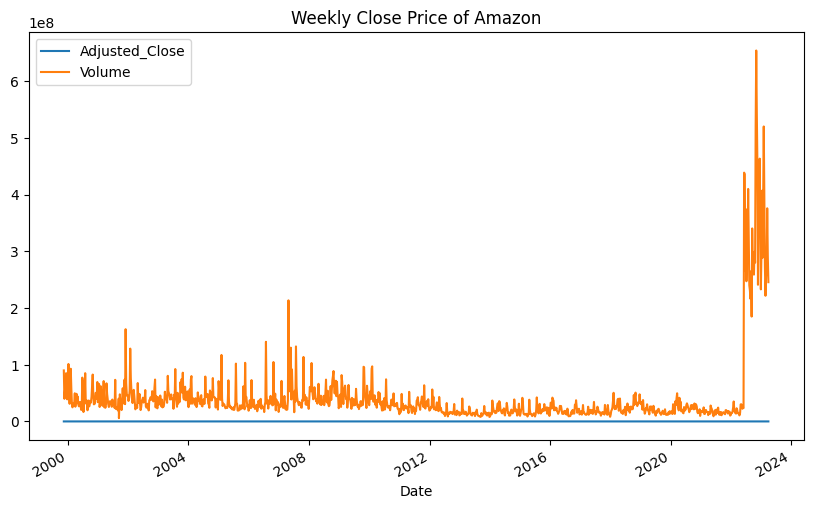

In [4]:
df.plot(figsize=(10,6))
plt.title('Weekly Close Price of Amazon')
plt.show()

## Checking Stationarity 

In [5]:
result = adfuller(df['Adjusted_Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -0.462745
p-value: 0.899084


## Differencing 

This makes the dataset stationary

In [6]:
df['Adjusted_Close'] = pd.to_numeric(df['Adjusted_Close'], errors='coerce')
# Assuming the series is not stationary, differencing is needed
df_diff = df.diff().dropna()
# Check stationarity again
result = adfuller(df_diff['Adjusted_Close'])
print('p-value after differencing: %f' % result[1])


p-value after differencing: 0.000000


## ACF & PACF

ACF and PACF plots are crucial for determining the parameters (p, d, q) for ARIMA models. The p and q parameters can be estimated from PACF and ACF plots, respectively.


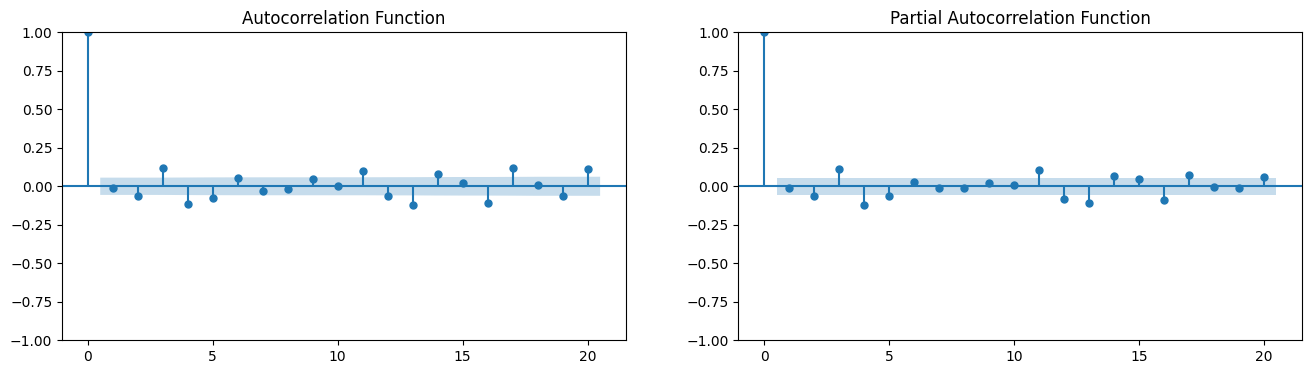

In [7]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

# ACF
plot_acf(df_diff['Adjusted_Close'], ax=ax1, lags=20)
ax1.set_title('Autocorrelation Function')

# PACF
plot_pacf(df_diff['Adjusted_Close'], ax=ax2, lags=20)
ax2.set_title('Partial Autocorrelation Function')

plt.show()


## Making the ARIMA Model - p, d, q selection

In [8]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Split the data into the dependent variable and the exogenous variables
y_train = train_df['Adjusted_Close']
X_train = train_df[['Volume']]  # Exogenous variable

# Fit the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(3, 2, 1))  # Replace p, d, q with chosen values
results = model.fit()

# Summary of the model
print(results.summary())

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Adjusted_Close   No. Observations:                 1221
Model:               SARIMAX(2, 2, 1)   Log Likelihood               -3052.947
Date:                Tue, 16 Jan 2024   AIC                           6115.894
Time:                        20:38:07   BIC                           6141.423
Sample:                             0   HQIC                          6125.503
                               - 1221                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Volume      -1.18e-08   1.29e-09     -9.172      0.000   -1.43e-08   -9.28e-09
ar.L1         -0.4428      0.007    -63.529      0.000      -0.456      -0.429
ar.L2         -0.3225      0.010    -33.775      0.0

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## Model Diagnostics

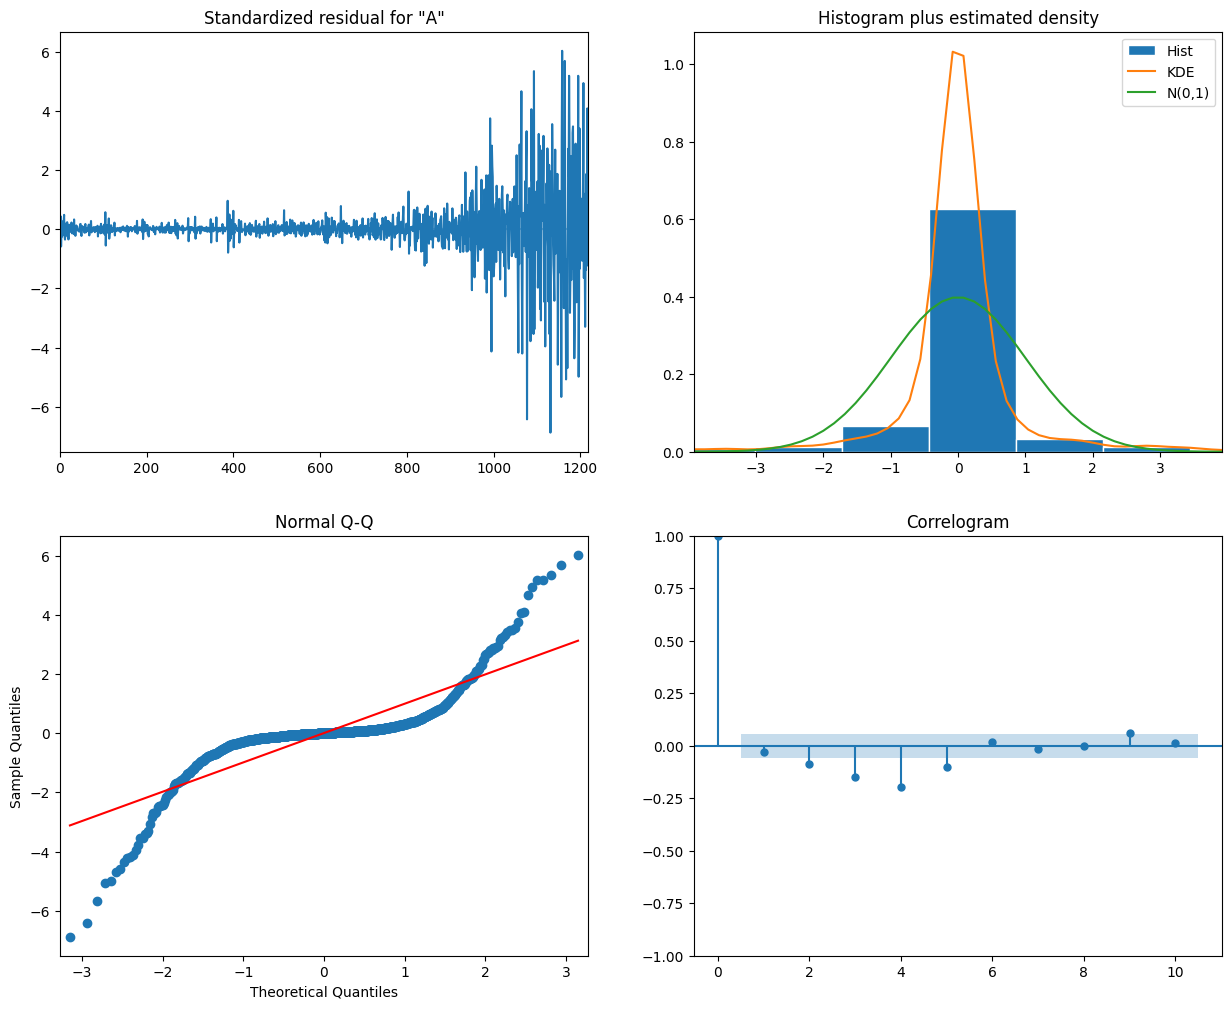

In [9]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()


## Prediction Graph

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


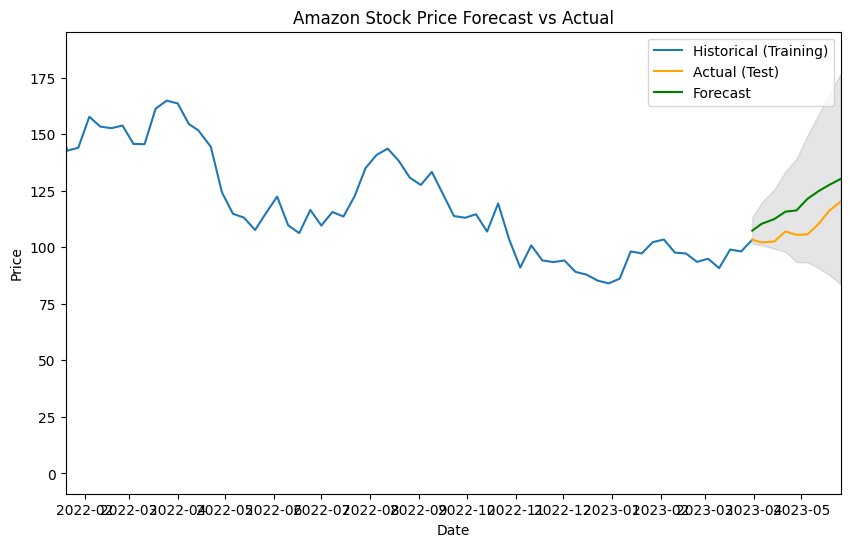

In [10]:
import matplotlib.dates as mdates

X_test = test_df[['Volume']]  # Exogenous variable for the test set

# Generate out-of-sample forecasts
forecast = results.get_forecast(steps=len(test_df), exog=X_test)
forecast_index = test_df.index  # Use the test set dates for the forecast index

# Confidence intervals for the forecast
forecast_ci = forecast.conf_int()

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Adjusted_Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Adjusted_Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], color='k', alpha=0.1)

# Set the xlim to show data from January 2022 onwards (or adjust as needed)
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

## RMSE & MAE

In [11]:
predicted_values = forecast.predicted_mean
actual_values = test_df['Adjusted_Close']

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  10.881082103030522
Mean Absolute Error:  10.387913449031355


## Optimising

In [12]:
import pmdarima as pm

# Prepare the exogenous variable (Volume) - ensure it's in the correct shape
exog_train = train_df[['Volume']]

# Using auto_arima with exogenous variables
best_model = pm.auto_arima(train_df['Adjusted_Close'], 
                           exogenous=exog_train,
                           seasonal=True,  # assuming the data could be seasonal
                           m=52,           # weekly data, so m might be 52 for yearly seasonality
                           stepwise=True,
                           trace=True,
                           error_action='ignore',
                           suppress_warnings=True,
                           max_p=5, max_q=5, max_d=2,
                           max_P=2, max_Q=2, max_D=1)

print(best_model.summary())


Performing stepwise search to minimize aic


KeyboardInterrupt: 

## Optimised Graph

c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


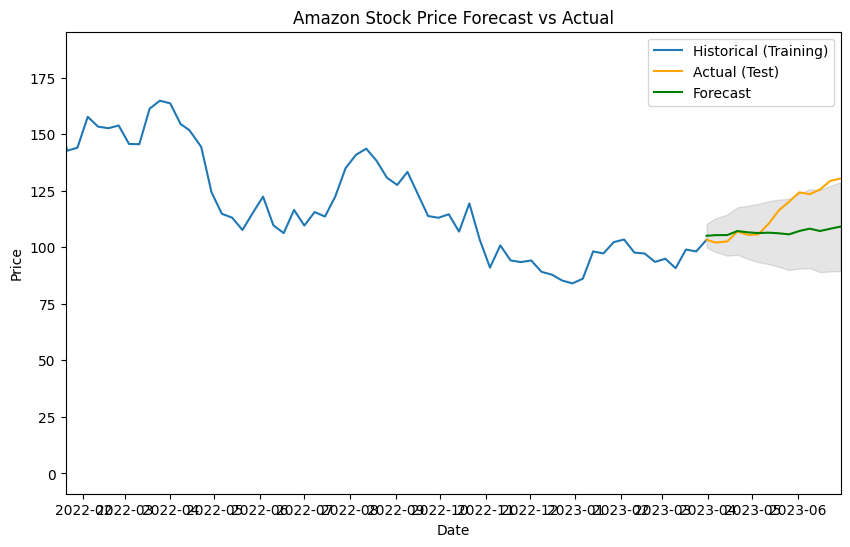

In [ ]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Prepare the exogenous variable for the test set
X_test = test_df[['Volume']]

# Generate out-of-sample forecasts
forecast, conf_int = best_model.predict(n_periods=len(test_df), exogenous=X_test, return_conf_int=True)
forecast_index = test_df.index  # Use the test set dates for the forecast index

# Plotting the forecast along with the test set
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Adjusted_Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Adjusted_Close'], label='Actual (Test)', color='orange')
plt.plot(forecast_index, forecast, label='Forecast', color='green')
plt.fill_between(forecast_index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='k', alpha=0.1)

# Set the xlim to show data from January 2022 onwards (or adjust as needed)
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('Amazon Stock Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
import matplotlib.dates as mdates

# Plot the forecast with confidence intervals
plt.figure(figsize=(10,6))
plt.plot(train_df.index, train_df['Close'], label='Historical (Training)')
plt.plot(test_df.index, test_df['Close'], label='Actual (Test)', color='orange')
plt.plot(test_df.index, forecast, label='Forecast', color='green')
plt.fill_between(test_df.index, 
                 conf_int[:, 0], 
                 conf_int[:, 1], color='grey', alpha=0.3)

# Set the xlim to show data from July 2023 onwards
plt.xlim([pd.Timestamp('2022-01-20'), test_df.index[-1]])

# (Optional) Set the format of the x-axis to better display the dates
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))

plt.title('SARIMAX Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate the date labels for better readability
plt.gcf().autofmt_xdate()

plt.show()


KeyError: 'Close'

<Figure size 1000x600 with 0 Axes>

## Optimised RSME & MAE

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Prepare the exogenous variable for the test set
X_test = test_df[['Volume']]  # Exogenous variable

# Generating the forecast for the entire duration of the test set
# Make sure to include the exogenous variable in the prediction
forecast, conf_int = best_model.predict(n_periods=len(test_df), exogenous=X_test, return_conf_int=True)

# The forecast index should align with the test set index length
forecast_index = test_df.index

# The predicted values should have the same length as the actual values
predicted_values = forecast

# Actual values from the test set
actual_values = test_df['Adjusted_Close']

# Calculate RMSE (Root Mean Squared Error)
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print("Root Mean Squared Error: ", rmse)

# Calculate MAE (Mean Absolute Error)
mae = mean_absolute_error(actual_values, predicted_values)
print("Mean Absolute Error: ", mae)


Root Mean Squared Error:  12.273090357312023
Mean Absolute Error:  9.37365076020014


c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\tuxo9\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
